In [86]:
import math
import json
import warnings
import numpy as np
import pandas as pd
import csv
import copy
import matplotlib.pyplot as plt

import glob
import os, sys

from collections import OrderedDict
from IPython.display import display, HTML

from cryptorandom.cryptorandom import SHA256, int_from_hash
from cryptorandom.sample import sample_by_index

from shangrla.core.Audit import Audit, Assertion, Assorter, Contest, CVR, Stratum
from shangrla.core.NonnegMean import NonnegMean
from shangrla.formats.Dominion import Dominion

### SF CVR download info
Download the SF CVRs from https://sfelections.org/results/20241105w/detail.html 

Under the 'Final Report' tab click "Cast Vote Record (Raw data) - JSON" to download a zip file with all the CVRs. You will edit the file path for 'cvr_file' below based on where you put the CVR folder once downloaded.

In [2]:
audit = Audit.from_dict({
         'seed':           12345678901234567890,
         'sim_seed':       314159265,
         'cvr_file':       './sf-cvrs-2024/CvrExport_*.json', # Edit with your file path
         'manifest_file':  './sf-cvrs-2024/BallotTypeManifest.json',
         'sample_file':    '...', # EDIT
         'mvr_file':       '...', # EDIT
         'log_file':       '...', # EDIT
         'quantile':       0.8,
         'error_rate_1':   0.001,
         'error_rate_2':   0.0,
         'reps':           200,
         'strata':         {'stratum_1': {'max_cards':   1603908, 
                                          'use_style':   True,
                                          'replacement': False
                                         }
                           }
        })

In [3]:
## Read the CVRs
# Group = 1 is precinct, 2 is vote-by-mail
# tally_pool will give precinct, pool will indicate if has CVRs
cvr_list = []
for _fname in glob.glob(audit.cvr_file):
    cvr_list.extend(Dominion.read_cvrs(_fname, use_current=True, enforce_rules=True, include_groups=[1,2],
                                      pool_groups=[1]))

In [8]:
# Tabulate votes for each contest
vote_tabulation = CVR.tabulate_votes(cvr_list)

In [9]:
# Mayor contest is contest ID 18
print(vote_tabulation['18']) # votes for candidates
print(sum(vote_tabulation['18'].values())) # total votes

defaultdict(<class 'int'>, {'55': 204829, '57': 257051, '62': 243460, '65': 31455, '64': 117898, '61': 192214, '54': 43067, '56': 53638, '58': 54318, '66': 68829, '59': 49611, '60': 34424, '63': 51138, '173': 29, '176': 9, '175': 10})
1401980


In [11]:
# Mayoral contest
contest_dict = {
               '18':{
                   'name': 'MAYOR',
                   'risk_limit':       0.05,
                   'cards':            1401980,
                   'choice_function':  Contest.SOCIAL_CHOICE_FUNCTION.PLURALITY,
                   'n_winners':        1,
                   'candidates':       ['54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '173', '175', '176'],
                   'winner':           ['57'],
                   'assertion_file':   None,
                   'audit_type':       Audit.AUDIT_TYPE.ONEAUDIT,
                   'test':             NonnegMean.alpha_mart,
                   'estim':            NonnegMean.shrink_trunc,
                   'test_kwargs':      {'d': 100, 'f': 0}
                  }
               }

contests = Contest.from_dict_of_dicts(contest_dict)

In [12]:
# construct the dict of dicts of assertions for each contest
Assertion.make_all_assertions(contests)

True

In [13]:
# check that the CVR IDs are unique
unique_ids = len(set(c.id for c in cvr_list))
print(f'cvrs: {len(cvr_list)} unique IDs: {unique_ids}')
assert unique_ids == len(cvr_list), 'CVR IDs are not unique'

cvrs: 1603908 unique IDs: 1603908


In [22]:
# ensure every CVR in each tally_pool has the same value of `pool`
cvr_list = CVR.check_tally_pools(cvr_list)
len(cvr_list)

1603908

In [14]:
# find the set of tally_pools for which pool==True
pools = set(c.tally_pool for c in cvr_list if c.pool)
len(pools)

4223

In [15]:
# make dict of all contest IDs mentioned in each tally_pool of CVRs for which pool==True
tally_pools = CVR.pool_contests(cvr_list)

# ensure every CVR in each tally_pool for which pool==True has every contest in that tally_pool
CVR.add_pool_contests(cvr_list, tally_pools)

True

In [16]:
# set pooled assorter means
for con in contests.values():
    for a in con.assertions.values():
        a.assorter.set_tally_pool_means(cvr_list=cvr_list, tally_pools=tally_pools)

In [71]:
# tally pool (batch) means for each contest as numpy array
tally_pool_means = pd.DataFrame(np.zeros((len(pools), len(contests['18'].assertions)))) # set dimensions and make pandas df
tally_pool_means.columns = contests['18'].assertions # set column names to names of assertions
tally_pool_means.index = pools


for n, a in contests['18'].assertions.items():
    for pool in pools:
        pm = a.assorter.tally_pool_means[pool]
        tally_pool_means.loc[pool,n] = pm

In [72]:
tally_pool_means

,57 v 175,57 v 64,57 v 59,57 v 61,57 v 173,57 v 63,57 v 60,57 v 62,57 v 56,57 v 66,57 v 65,57 v 55,57 v 58,57 v 176,57 v 54
43-27,0.551948,0.512987,0.519481,0.487013,0.551948,0.519481,0.525974,0.454545,0.525974,0.525974,0.525974,0.500000,0.506494,0.551948,0.519481
27-476,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.375000,0.500000,0.500000,0.500000,0.437500,0.500000,0.500000,0.500000
612-0,0.575235,0.543887,0.562696,0.529781,0.575235,0.559561,0.567398,0.484326,0.559561,0.553292,0.567398,0.504702,0.554859,0.575235,0.562696
27-510,0.562500,0.500000,0.562500,0.500000,0.562500,0.562500,0.562500,0.437500,0.562500,0.500000,0.562500,0.500000,0.562500,0.562500,0.562500
986-0,0.573034,0.535581,0.552434,0.522472,0.573034,0.554307,0.558052,0.513109,0.558052,0.541199,0.563670,0.509363,0.565543,0.573034,0.561798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43-96,0.550000,0.550000,0.550000,0.550000,0.550000,0.550000,0.550000,0.550000,0.550000,0.525000,0.550000,0.500000,0.550000,0.550000,0.550000
24-165,0.550000,0.500000,0.550000,0.475000,0.550000,0.475000,0.525000,0.525000,0.550000,0.550000,0.550000,0.500000,0.525000,0.525000,0.525000
36-335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28-90,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000


In [80]:
# reported assorter margins for each assertion, and the minimum margin, which drives the sample sizes
min_margin = Assertion.set_all_margins_from_cvrs(audit=audit, contests=contests, cvr_list=cvr_list)

print(f'minimum assorter margin: {min_margin}')
Contest.print_margins(contests)

minimum assorter margin: 0.0239447637236212
margins in contest 18:
	assertion 57 v 175: 0.4528574801179708
	assertion 57 v 64: 0.2451611880239184
	assertion 57 v 59: 0.36546992766006925
	assertion 57 v 61: 0.11423049411731534
	assertion 57 v 173: 0.4528240057223598
	assertion 57 v 63: 0.3627796433391237
	assertion 57 v 60: 0.3922265406150127
	assertion 57 v 62: 0.0239447637236212
	assertion 57 v 56: 0.3583751176008372
	assertion 57 v 66: 0.33161145740471243
	assertion 57 v 65: 0.39745735538180194
	assertion 57 v 55: 0.09200525724192121
	assertion 57 v 58: 0.35717708660002323
	assertion 57 v 176: 0.4528592419282662
	assertion 57 v 54: 0.3769992142326082


(array([1.40e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 1.10e+01, 1.00e+00, 1.00e+00, 1.70e+01, 3.25e+02,
        6.20e+01, 3.61e+02, 5.52e+02, 2.13e+03, 2.55e+02, 3.40e+01,
        2.02e+02, 0.00e+00, 1.10e+01, 0.00e+00, 8.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 9.00e+00]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

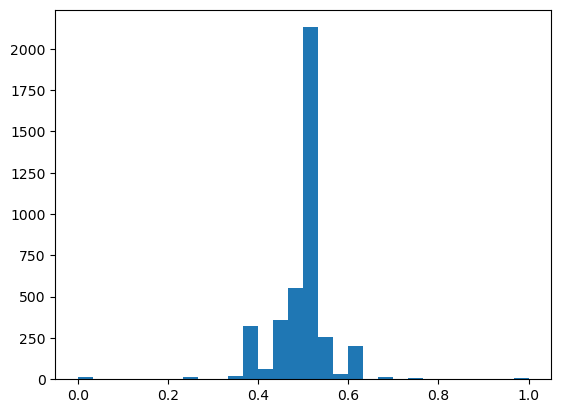

In [88]:
plt.hist(tally_pool_means['57 v 62'], bins = 30)

In [73]:
# CVR value: 1 / (2 - v_global)
sum([1 if c.pool == False else 0 for c in cvr_list]) # Vote by mail

1387622

In [74]:
sum([1 if c.pool == True else 0 for c in cvr_list]) # Precinct

216286

In [75]:
# Get number of CVRs in each precinct
precinct_dict = {}

for c in cvr_list:
    if c.pool == True:
        if c.tally_pool in precinct_dict:
            precinct_dict[c.tally_pool] += 1
        else:
            precinct_dict[c.tally_pool] = 1

In [76]:
sum(precinct_dict.values()) # Check that sums to precinct CVR count

216286

In [77]:
len(precinct_dict.keys())

4223

In [78]:
precinct_df = pd.DataFrame(list(precinct_dict.items()), columns=['Precinct ID', 'Total Votes'])

In [46]:
#precinct_df.to_csv("~/Downloads/precinct_df.csv")

,Precinct ID,Number
0,39-190,4
1,36-15,4
2,27-535,4
3,43-170,8
4,27-448,20
...,...,...
4218,27-157,4
4219,24-151,4
4220,27-415,8
4221,615-0,124
